In [1]:
# Install packages
!pip install openpyxl
!pip install pandas

                                              0.0/251.4 kB ? eta -:--:--
     -----------------                      112.6/251.4 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 251.4/251.4 kB 3.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import subprocess
import os
import re
import shutil
import openpyxl
import pandas as pd

In [3]:
# Path to Optistruct Exceutable
optistruct_path = r"C:\Program Files\Altair\Solver\2017\hwsolvers\scripts\optistruct.bat"
# Path to directory where all brackets .fem shall be
directory = r"C:\Users\p.ballesteros\Documents\files\\"
# Path to the excel file that will have all the reuslts
results_file = r"C:\Users\p.ballesteros\Documents\Results.xlsx"
# Excel file with all materials and its properties 
input_excel_emissions = r"C:\Users\p.ballesteros\Documents\Materials.xlsx"

In [71]:
# Function to check if a file exists
def file_exists(path):
    return os.path.isfile(path)

# Check if the OptiStruct executable exists
if not os.path.isfile(optistruct_path):
    raise FileNotFoundError(f"The OptiStruct executable was not found at {optistruct_path}")

def dir_exists(path):
    return os.path.isdir(path)

def delete_non_fem_files(directory):
    files = os.listdir(directory)
    for file_name in files:
        file_path = os.path.join(directory, file_name)

        if os.path.isfile(file_path) and not file_name.endswith('.fem'):
            os.remove(file_path)
            
# Function that runs the Optistruct Executable
def ExecuteCommand (optistruct_path, input_fem_path):
        command = [optistruct_path, input_fem_path]
        print(f"I am working with file {file_name} "  )
        try:

            result = subprocess.run(command, check=True, capture_output=True, text=True)
            print("Command executed successfully.")
            print("Standard Output:\n", result.stdout)
            print("Standard Error:\n", result.stderr)

        except subprocess.CalledProcessError as e:
           
            # Print the error if the command fails
            print("Error in executing the command.")
            print("Return Code:", e.returncode)
            print("Standard Output:\n", e.stdout)
            print("Standard Error:\n", e.stderr)
        except Exception as e:
            print("An unexpected error occurred.")
            print(str(e))

# Function to extract mass from the .out file
def extract_mass(file_path):
    # Reading the file
    with open(file_path, 'r') as file:
        out_content = file.read()
        match = re.search(r'Mass\s+=\s+([\d.E+-]+)', out_content)
        if match:
            mass_value = float(match.group(1))*1000
            print(f"The mass is: {mass_value} kg")
            return mass_value

# Function to extract the Maximum displacement and VM stresses from .html
def extract_values_from_html(file_path): 
    with open(file_path, 'r') as file:
        content = file.read()
    displacement_pattern = re.compile(r'Maximum displacement is\s+([\d\.]+)', re.IGNORECASE)
    stress_pattern = re.compile(r'Maximum 3-D element stress is\s+([\d\.E\+]+)', re.IGNORECASE)
    displacements = displacement_pattern.findall(content)
    stresses = stress_pattern.findall(content)

    if not displacements:
        raise ValueError("No displacement values found in the HTML content.")
    if not stresses:
        raise ValueError("No stress values found in the HTML content.")
    displacements = [float(d) for d in displacements]
    stresses = [float(s.replace('E', 'e')) for s in stresses]  # Handle scientific notation
    max_displacement = max(displacements)
    max_stress = max(stresses)
    print(f"Maximum Displacement: {max_displacement}")
    print(f"Maximum von Mises Stress: {max_stress}")
    return max_displacement, max_stress

# Function to write the outputs on an Excel. It creates one automatically if not created
def write_to_excel(data, results_file):
    if os.path.exists(results_file):
        workbook = openpyxl.load_workbook(results_file)
        sheet = workbook.active
    else:
        
        workbook = openpyxl.Workbook()
        sheet = workbook.active
        title = ['Name', 'Material', 'Mass [kg]', 'Max VM [MPa]', 'SF' ,'Max Disp [mm]', 'CO2 [t]', 'Energy [J]', 'Water [L]', 'Cost [$]']
        sheet.append(title)
    
    exists = False
    for row in sheet.iter_rows(min_row=2, values_only=True):
        if row[:2] == (data[0], data[1]):
            exists = True
            break
    
    if not exists:
        sheet.append(data)
        # Save the Excel file
        workbook.save(results_file)
    else:
        print("Data already exists in the Excel file.")

# This changes the number format of the density. Excel gives it in the form e-9, while .fem only reads -9.
def scientific_to_fem_format(number):
    # Convert the number to scientific notation string
    sci_str = f"{number:.2e}"
    # Replace 'e' with a dash and remove the '+' if present
    fem_format = sci_str.replace('e', '').replace('+', '')
    return fem_format

# Changes the MAT1 line and introduces new values of E, rho, nu. It does it manually because it has to be very
# specific

def modify_material_properties(file_path, E, nu, rho):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Define the prefix of the line we're looking for
    line_prefix = "MAT1"

    # Modify the material properties
    with open(file_path, 'w') as file:
        for line in lines:
            if line.startswith(line_prefix):
                # Format the new properties
                formatted_E = f"{E:.1f}"
                formatted_nu = f"{nu:.3f}"
                formatted_rho = scientific_to_fem_format(rho)            
                if len(str(int(E))) < 6:
                    new_line = f"{line_prefix}{' ' * 11}1{formatted_E}{' ' * 9}{formatted_nu}{' ' * 3}{formatted_rho}\n"
                else:
                    new_line = f"{line_prefix}{' ' * 11}1{formatted_E}{' ' * 8}{formatted_nu}{' ' * 3}{formatted_rho}\n"
               
                line = new_line

    
            file.write(line)
    return print("Material changes made.")


# Function reads the input material file
def extract_material_data(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Extract data into different vectors
    mat = df['Material'].tolist()
    material_class = df['Class'].tolist()
    class_id = df['Class_id'].tolist()
    youngs_modulus = df['E [MPa]'].tolist()
    cost_per_kg = df['Cost [$/kg]'].tolist()
    mass_density = df['Density [t/mm^3]'].tolist()
    poisson = df['Poisson [-]'].tolist()
    co2_kg = df['CO2 [kg/kg]'].tolist()
    energy_kg = df['Energy [J/kg]'].tolist()
    water_kg = df['Water [L/kg]'].tolist()
    yield_strength = df['Yield_Str [MPa]'].tolist()
    
    data_vectors = {
        'Mat': mat,
        'Class': material_class,
        'Class_id': class_id,
        'E': youngs_modulus,
        'Cost': cost_per_kg,
        'Density': mass_density,
        'Poisson': poisson,
        'CO2': co2_kg,
        'Energy': energy_kg,
        'Water': water_kg,
        'Yield': yield_strength
    }

    return data_vectors

# Function creates the impact of the bracket
def footprint_and_output_vector (bracket, mass, max_disp, max_VM, data, i ):
        CO2 = mass * data['CO2'][i]/1000 + 98.8*mass  # production + in service
        E   = mass * data['Energy'][i]
        water = mass * data['Water'][i]
        cost = mass  *data['Cost'][i]
        SF = data['Yield'][i] / max_VM
        data = [bracket, data['Mat'][i] , mass, max_VM, SF,  max_disp, CO2 , E, water, cost ]
        return data


In [73]:

files = os.listdir(directory)
print(files)
data = extract_material_data(input_excel_emissions)
number_of_materials = len(next(iter(data.values())))


for file_name in files:   # for each bracket
        
    for i in range(0, number_of_materials): # for each material
        print(f"Processing material {data['Mat'][i]}")
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
             modify_material_properties(file_path, data['E'][i], data['Poisson'][i], data['Density'][i])
             ExecuteCommand (optistruct_path, file_path)
             mass = extract_mass(os.path.join(directory, os.path.splitext(file_name)[0] + ".out"))
             max_displacement, max_stress = extract_values_from_html(file_path.replace('.fem', '.html'))
             output_data = footprint_and_output_vector(file_name.split('.')[0], mass, max_displacement, max_stress, data, i)
             write_to_excel(output_data, results_file)
             delete_non_fem_files(directory)
    
print('END')
        

['10.fem', '311.fem']
Processing material BeCu C17000
Material changes made.
I am working with file 10.fem 
Command executed successfully.
Standard Output:
  ************************************************************************
 **                                                                    **
 **                                                                    **
 **                         OptiStruct 2017.2                          **
 **                                                                    **
 **             Advanced Engineering Analysis, Design and              **
 **        Optimization Software from Altair Engineering, Inc.         **
 **                                                                    **
 **                                                                    **
 **               Windows 10  (Build 9200)  PCB61-01-12                **
 **          8 CPU:  Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz           **
 **                    25065 

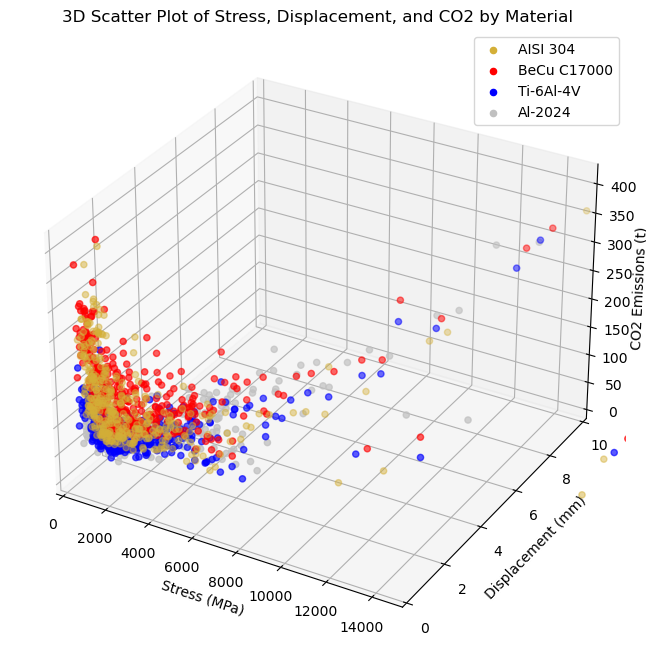

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

data = pd.read_excel("/Users/Ricard/Downloads/RP/FinalResults.xlsx")

stress_col = "Max VM [MPa]"
displacement_col = "Max Disp [mm]"
co2_col = "CO2 [t]"
material_col = "Material"

materials = ["AISI 304", "BeCu C17000", "Ti-6Al-4V", "Al-2024"]
material_data = {mat: data[data[material_col] == mat] for mat in materials}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = {"AISI 304": "#D4AF37", "BeCu C17000": "#FF0000", "Al-2024": "#C0C0C0", "Ti-6Al-4V": "#0000FF"}

for mat in materials:
    subset = material_data[mat]
    ax.scatter(subset[stress_col], subset[displacement_col], subset[co2_col], c=colors[mat], label=mat)

ax.set_xlabel("Stress (MPa)")
ax.set_ylabel("Displacement (mm)")
ax.set_zlabel("CO2 Emissions (t)", labelpad=0)
ax.set_title("3D Scatter Plot of Stress, Displacement, and CO2 by Material")
ax.legend()
ax.set_ylim(0, 10)
ax.set_xlim(0, 15000)
plt.savefig("3dplotdata.png", dpi=300)
plt.show()